In [1]:
import matplotlib.pyplot as plt  # 画图模块
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from matplotlib import style
import matplotlib.dates as mdates
from pandas._libs.tslibs.offsets import MonthEnd

# from matplotlib.font_manager import FontProperties # 作图中文
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang HK', 'STHeiti', 'SimHei'] # Mac系统支持的中文字体
plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

# Risk-Free Rate

In [26]:
# Load Risk Free Rate
riskfree = pd.read_csv('Data/TRD_Nrrate2024.csv')
riskfree_mon = riskfree[['Clsdt', 'Nrrmtdt']].dropna()
riskfree_mon = riskfree_mon.drop([0,1])
riskfree_mon['month'] = pd.to_datetime(riskfree_mon['Clsdt'])+MonthEnd(0)
riskfree_mon['rfmonth'] = riskfree_mon['Nrrmtdt'].astype(float) / 100
riskfree_mon = riskfree_mon.groupby('month').agg({'rfmonth':'mean'}).reset_index()
riskfree_mon

,month,rfmonth
0,1990-12-31,0.006930
1,1991-01-31,0.006930
2,1991-02-28,0.006930
3,1991-03-31,0.006930
4,1991-04-30,0.006651
...,...,...
404,2024-08-31,0.001118
405,2024-09-30,0.001118
406,2024-10-31,0.001118
407,2024-11-30,0.001118


# 个股月收益率

- Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准
- Trdmnt [交易月份] - 以YYYY-MM表示
- Opndt [月开盘日期] - 月第一个交易日。以DD表示，为OPNPRC的所在日，“DD”＝本月无交易
- Mopnprc [月开盘价] - 月第一个交易日的开盘价。
- Clsdt [月收盘日期] - 月最后一个交易日。以DD表示，为CLSPRC的所在日，“DD”＝本月无交易
- Mclsprc [月收盘价] - 月最后一个交易日的收盘价。
- Mnshrtrd [月个股交易股数] - 月内该股票的交易数量。计算公式为：月开盘日期与交易日期期间内日成交量之和。
- Mnvaltrd [月个股交易金额] - 月内该股票的交易金额。计算公式为：月开盘日期与交易日期期间内日成交额之和。A股以人民币元计，上海B以美元计，深圳B以港币计。
- Msmvosd [月个股流通市值] - 个股的流通股数与月收盘价的乘积。计算公式为：个股的流通股数与月收盘价的乘积。 A股以人民币元计，上海B以美元计，深圳B以港币计，注意单位是千
- Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积。计算公式为：个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千
- Ndaytrd [月交易天数] - 计算公式为：月内实际交易的天数之和。
- Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Mretnd [不考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Markettype [市场类型] - 1=上证A股市场 (不包含科创板），2=上证B股市场，4=深证A股市场（不包含创业板），8=深证B股市场，16=创业板， 32=科创板，64=北证A股市场。
- Capchgdt [最新股本变动日期] - 上市公司最近一次股本发生变化的日期
- Ahshrtrd_M [月盘后成交总量] - 月科创板股票盘后总成交量。计算公式为：月开盘日期与交易日期期间内日盘后成交量之和。
- Ahvaltrd_M [月盘后成交总额] - 月科创板股票盘后总成交额。计算公式为：月开盘日期与交易日期期间内日盘后成交额之和。

In [27]:
ret_mon = (
    pd.read_csv('Data/TRD_Mnth199012-202412.csv')
    [[
        'Stkcd',
        'Trdmnt',
        'Ndaytrd',
        'Msmvosd',
        'Msmvttl',
        'Mretwd',
        'Markettype',
    ]]
)
ret_mon = ret_mon.rename(
    columns={
        'Trdmnt': 'month',
        'Ndaytrd': 'Freq',
        'Msmvosd': 'floatingvalue',
        'Msmvttl': 'totalvalue',
        'Mretwd': 'Return',
    }
)
ret_mon['floatingvalue'] = pd.to_numeric(ret_mon['floatingvalue'], errors='coerce') * 1000
ret_mon['totalvalue'] = pd.to_numeric(ret_mon['totalvalue'], errors='coerce') * 1000
ret_mon['Return'] = pd.to_numeric(ret_mon['Return'], errors='coerce')
ret_mon['month'] = pd.to_datetime(ret_mon['month']).dt.to_period('M').dt.to_timestamp('M')
ret_mon['Freq'] = pd.to_numeric(ret_mon['Freq'], errors='coerce')
ret_mon['Markettype'] = pd.to_numeric(ret_mon['Markettype'], errors='coerce')
ret_mon = ret_mon[ret_mon['Markettype'].isin([1, 4, 16])]
ret_mon = ret_mon.merge(riskfree_mon, on='month', how='left')
ret_mon = ret_mon.sort_values(['Stkcd', 'month']).reset_index(drop=True)
ret_mon['Stkcd'] = ret_mon['Stkcd'].astype(str).str.zfill(6)
ret_mon['ret'] = ret_mon['Return'] - ret_mon['rfmonth']
# 计算每个公司从上市开始的月份数（使用日历月份）
# 首先获取每个公司最早的交易月份作为上市月份
first_month = ret_mon.groupby('Stkcd')['month'].transform('min')
# 计算每个观测值距离上市月份的月份差
ret_mon['listing_month'] = ((ret_mon['month'].dt.year - first_month.dt.year) * 12 + 
                           (ret_mon['month'].dt.month - first_month.dt.month) + 1)
ret_mon = ret_mon.sort_values(['Stkcd', 'month']).reset_index(drop=True)
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month
0,000001,1991-04-30,20,1.157520e+09,2.118487e+09,NaN,4,0.006651,NaN,1
1,000001,1991-05-31,24,1.016010e+09,1.859497e+09,-0.122253,4,0.006092,-0.128345,2
2,000001,1991-06-30,23,9.007350e+08,1.648521e+09,-0.113459,4,0.006092,-0.119551,3
3,000001,1991-07-31,16,7.828100e+08,1.432695e+09,-0.130921,4,0.006092,-0.137013,4
4,000001,1991-08-31,15,6.748338e+08,1.346275e+09,-0.411588,4,0.006092,-0.417680,5
...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39


接下来的任务是在数据中添加列为未来的收益率：例如t+1月、。。。、t+12月的收益率

In [28]:
# 为每个股票创建未来1-12个月的收益率
for i in range(1, 13):
    # 创建一个临时列，将月份向前移动i个月，使用月末日期
    ret_mon[f'future_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'future_month_{i}'] = ret_mon[f'future_month_{i}'] + pd.DateOffset(months=i)+MonthEnd(0)
    
    # 使用merge来匹配未来月份的收益率，确保使用月末日期进行匹配
    future_returns = ret_mon[['Stkcd', 'month', 'ret']].copy()
    future_returns['month'] = future_returns['month'].dt.to_period('M').dt.to_timestamp('M')
    future_returns = future_returns.rename(
        columns={'month': f'future_month_{i}', 'ret': f'ret_t{i}'}
    )
    
    # 将未来收益率合并到原始数据中
    ret_mon = ret_mon.merge(
        future_returns,
        on=['Stkcd', f'future_month_{i}'],
        how='left'
    )
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'future_month_{i}'])

# 显示结果
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month,ret_t1,ret_t2,ret_t3,ret_t4,ret_t5,ret_t6,ret_t7,ret_t8,ret_t9,ret_t10,ret_t11,ret_t12
0,000001,1991-04-30,20,1.157520e+09,2.118487e+09,NaN,4,0.006651,NaN,1,-0.128345,-0.119551,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835
1,000001,1991-05-31,24,1.016010e+09,1.859497e+09,-0.122253,4,0.006092,-0.128345,2,-0.119551,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934
2,000001,1991-06-30,23,9.007350e+08,1.648521e+09,-0.113459,4,0.006092,-0.119551,3,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888
3,000001,1991-07-31,16,7.828100e+08,1.432695e+09,-0.130921,4,0.006092,-0.137013,4,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888,0.079622
4,000001,1991-08-31,15,6.748338e+08,1.346275e+09,-0.411588,4,0.006092,-0.417680,5,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888,0.079622,-0.101487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36,0.105958,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 数据过滤

- 删除交易较少的股票 Freq
- 删除IPO不足12个月/6个月的股票
- 删除Return缺失的股票
- 过去12个月交易日不足120天的股票

In [29]:
# 计算过去12个月的交易频率总和
ret_mon['past_12m_freq'] = ret_mon['Freq']  # 初始化为本月频率

# 对每个股票计算过去11个月（加上本月共12个月）的交易频率总和
for i in range(1, 12):  # 改为1到11，因为本月已经包含在初始值中: 1-11已经
    # 创建临时列，将月份向后移动i个月
    ret_mon[f'past_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'past_month_{i}'] = ret_mon[f'past_month_{i}'] - pd.DateOffset(months=i)+MonthEnd(0)
    
    # 使用merge来匹配过去月份的Freq
    past_freq = ret_mon[['Stkcd', 'month', 'Freq']].copy()
    past_freq['month'] = past_freq['month'].dt.to_period('M').dt.to_timestamp('M')
    past_freq = past_freq.rename(
        columns={'month': f'past_month_{i}', 'Freq': f'freq_t{i}'}
    )
    
    # 将过去Freq合并到原始数据中
    ret_mon = ret_mon.merge(
        past_freq,
        on=['Stkcd', f'past_month_{i}'],
        how='left'
    )
    
    # 累加到past_12m_freq中
    ret_mon['past_12m_freq'] += ret_mon[f'freq_t{i}'].fillna(0)
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'past_month_{i}', f'freq_t{i}'])

print("过去12个月（含本月）交易频率总和的计算完成")
print(ret_mon[['Stkcd', 'month', 'past_12m_freq']].head())


过去12个月（含本月）交易频率总和的计算完成
    Stkcd      month  past_12m_freq
0  000001 1991-04-30           20.0
1  000001 1991-05-31           44.0
2  000001 1991-06-30           67.0
3  000001 1991-07-31           83.0
4  000001 1991-08-31           98.0


In [30]:
ret_mon = ret_mon[
    (ret_mon['past_12m_freq'] > 120) & 
    (ret_mon['listing_month'] > 12) & 
    (ret_mon['Freq'] > 7)
]
ret_mon.dropna(subset=['Return'], inplace=True)
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month,ret_t1,ret_t2,ret_t3,ret_t4,ret_t5,ret_t6,ret_t7,ret_t8,ret_t9,ret_t10,ret_t11,ret_t12,past_12m_freq
12,000001,1992-04-30,22,2.599445e+09,5.185820e+09,0.477927,4,0.006092,0.471835,13,0.167934,-0.076888,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,260.0
13,000001,1992-05-31,21,3.051816e+09,6.088287e+09,0.174026,4,0.006092,0.167934,14,-0.076888,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,257.0
14,000001,1992-06-30,22,2.835758e+09,5.657258e+09,-0.070796,4,0.006092,-0.076888,15,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,256.0
15,000001,1992-07-31,23,3.078823e+09,6.142166e+09,0.085714,4,0.006092,0.079622,16,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,-0.090366,263.0
16,000001,1992-08-31,21,2.785120e+09,5.556236e+09,-0.095395,4,0.006092,-0.101487,17,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,-0.090366,-0.047337,269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36,0.105958,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.0
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.0


# Function

## 构造投资组合

In [11]:
def construct_anomaly_portfolio(data, sort_variable, n_groups=10, ascending=True, 
                               future_return_col='ret_t1', start_date=None, end_date=None,
                               weight_method='totalvalue'):
    """
    构造基于任意变量的异象投资组合
    
    参数:
    data: 包含股票数据的DataFrame
    sort_variable: 用于分组的变量名（字符串），如'totalvalue', 'floatingvalue'等
    n_groups: 分组数量，默认为10组
    ascending: 排序方向，True表示升序（小值在前），False表示降序（大值在前）
    future_return_col: 未来收益率列名，默认为'ret_t1'
    start_date: 样本起始时间，格式为'YYYY-MM-DD'或datetime
    end_date: 样本结束时间，格式为'YYYY-MM-DD'或datetime
    weight_method: 加权方法，可选：
                  - 'totalvalue': 总市值加权（默认）
                  - 'floatingvalue': 流通市值加权
                  - 'equal': 等权重
    
    返回:
    portfolio_returns: 包含各组合收益率的DataFrame
    """
    
    # 验证权重方法参数
    valid_weight_methods = ['totalvalue', 'floatingvalue', 'equal']
    if weight_method not in valid_weight_methods:
        raise ValueError(f"weight_method必须是以下之一: {valid_weight_methods}")
    
    # 时间筛选
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        data = data[data['month'] >= start_date]
    
    if end_date is not None:
        end_date = pd.to_datetime(end_date)
        data = data[data['month'] <= end_date]
    
    # 创建结果存储列表
    portfolio_results = []
    
    # 获取所有月份
    months = sorted(data['month'].unique())
    
    for month in months:
        # 获取当月数据
        month_data = data[data['month'] == month].copy()
        
        # 根据权重方法确定需要的列
        required_cols = [sort_variable, future_return_col]
        if weight_method in ['totalvalue', 'floatingvalue']:
            required_cols.append(weight_method)
        
        # 过滤掉缺失值
        month_data = month_data.dropna(subset=required_cols)
        
        if len(month_data) < n_groups:
            continue
            
        # 按指定变量分组
        try:
            month_data['rank'] = pd.qcut(month_data[sort_variable], 
                                       q=n_groups, 
                                       labels=False, 
                                       duplicates='drop')
        except ValueError:
            # 如果qcut失败（比如重复值太多），使用rank方法
            month_data['rank'] = pd.qcut(month_data[sort_variable].rank(method='first'), 
                                       q=n_groups, 
                                       labels=False)
        
        # 如果是降序排列，需要反转排名
        if not ascending:
            month_data['rank'] = n_groups - 1 - month_data['rank']
        
        # 计算每组的加权收益率
        group_returns = {}
        
        for group in range(n_groups):
            group_data = month_data[month_data['rank'] == group]
            
            if len(group_data) > 0:
                if weight_method == 'equal':
                    # 等权重
                    weighted_return = group_data[future_return_col].mean()
                else:
                    # 市值加权（总市值或流通市值）
                    weights = group_data[weight_method]
                    total_weight = weights.sum()
                    
                    if total_weight > 0:
                        weighted_return = (group_data[future_return_col] * weights).sum() / total_weight
                    else:
                        weighted_return = np.nan
                
                group_returns[f'Group_{group+1}'] = weighted_return
            else:
                group_returns[f'Group_{group+1}'] = np.nan
        
        # 计算多空组合收益率（买入第1组，卖出第n组）
        if f'Group_1' in group_returns and f'Group_{n_groups}' in group_returns:
            if not (pd.isna(group_returns[f'Group_1']) or pd.isna(group_returns[f'Group_{n_groups}'])):
                long_short_return = group_returns[f'Group_1'] - group_returns[f'Group_{n_groups}']
                group_returns['Long_Short'] = long_short_return
            else:
                group_returns['Long_Short'] = np.nan
        else:
            group_returns['Long_Short'] = np.nan
        
        # 添加月份信息
        group_returns['month'] = month
        portfolio_results.append(group_returns)
    
    # 转换为DataFrame
    portfolio_df = pd.DataFrame(portfolio_results)
    portfolio_df = portfolio_df.set_index('month').sort_index()
    
    # 移除非数值列
    numeric_cols = portfolio_df.select_dtypes(include=[np.number]).columns
    portfolio_df = portfolio_df[numeric_cols]
    
    return portfolio_df

## 组合分析函数

In [12]:
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.stattools import acf

# Newey-West调整的t统计量计算函数
def calculate_newey_west_tstat(returns, max_lags=None):
    """
    计算Newey-West调整的t统计量
    
    参数:
    returns: 收益率序列
    max_lags: 最大滞后期数，如果为None则自动选择
    
    返回:
    t_stat: Newey-West调整的t统计量
    nw_se: Newey-West标准误
    """
    
    returns = returns.dropna()
    n = len(returns)
    
    if n < 2:
        return np.nan, np.nan
    
    # 如果没有指定最大滞后期，使用常用的公式
    if max_lags is None:
        # Newey-West建议的滞后期选择：floor(4*(T/100)^(2/9))
        max_lags = int(np.floor(4 * (n / 100) ** (2/9)))
        max_lags = max(1, min(max_lags, n // 4))  # 确保滞后期合理
    
    # 构造回归：returns = alpha + error
    # 这里我们测试均值是否显著不为0
    X = np.ones((n, 1))  # 常数项
    y = returns.values.reshape(-1, 1)
    
    try:
        # 使用OLS估计
        model = sm.OLS(y, X)
        results = model.fit()
        
        # 计算Newey-West协方差矩阵
        nw_cov = cov_hac(results, nlags=max_lags)
        nw_se = np.sqrt(nw_cov[0, 0])
        
        # 计算t统计量
        mean_return = returns.mean()
        t_stat = mean_return / nw_se
        
        return t_stat, nw_se
        
    except:
        # 如果计算失败，返回传统t统计量
        mean_return = returns.mean()
        std_error = returns.std() / np.sqrt(n)
        t_stat = mean_return / std_error
        return t_stat, std_error
    
# 修改分析函数，显示使用的权重方法
def analyze_portfolio_performance(portfolio_df, portfolio_name="投资组合", 
                                  weight_method="totalvalue",
                                    start_date=None, end_date=None, 
                                    plot_cumulative=True, nw_lags=None):
    """
    分析投资组合的表现（包含权重方法信息）
    """
    
    # 时间筛选
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        portfolio_df = portfolio_df[portfolio_df.index >= start_date]
    
    if end_date is not None:
        end_date = pd.to_datetime(end_date)
        portfolio_df = portfolio_df[portfolio_df.index <= end_date]
    
    # 权重方法的中文描述
    weight_descriptions = {
        'totalvalue': '总市值加权',
        'floatingvalue': '流通市值加权',
        'equal': '等权重'
    }
    
    print(f"\n{'='*60}")
    print(f"{portfolio_name} 投资组合分析报告")
    print(f"加权方法: {weight_descriptions.get(weight_method, weight_method)}")
    print(f"分析期间: {portfolio_df.index.min().strftime('%Y-%m')} 至 {portfolio_df.index.max().strftime('%Y-%m')}")
    print(f"{'='*60}")
    
    # 其余分析代码与之前相同...
    # 基本统计信息
    print(f"\n=== 基本统计信息 ===")
    print(portfolio_df.describe())
    
    # 各组合平均收益率
    print(f"\n=== 各组合平均月收益率 ===")
    mean_returns = portfolio_df.mean()
    print(mean_returns)
    
    # 详细分析多空组合
    stats_dict = {}
    if 'Long_Short' in portfolio_df.columns:
        long_short_stats = portfolio_df['Long_Short'].dropna()
        if len(long_short_stats) > 0:
            # 计算各种统计指标
            mean_return = long_short_stats.mean()
            std_return = long_short_stats.std()
            annual_return = mean_return * 12
            annual_vol = std_return * np.sqrt(12)
            sharpe_ratio = mean_return / std_return if std_return > 0 else np.nan
            
            # 计算传统t统计量
            traditional_t_stat = mean_return / (std_return / np.sqrt(len(long_short_stats))) if std_return > 0 else np.nan
            
            # 计算Newey-West调整的t统计量
            nw_t_stat, nw_se = calculate_newey_west_tstat(long_short_stats, max_lags=nw_lags)
            
            win_rate = (long_short_stats > 0).mean()
            
            # 计算最大回撤
            cumulative_returns = (1 + long_short_stats).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = drawdown.min()
            
            print(f"\n=== 多空组合(Long_Short)详细统计 ===")
            print(f"观测数量: {len(long_short_stats)}")
            print(f"平均月收益率: {mean_return:.4f} ({mean_return*100:.2f}%)")
            print(f"年化收益率: {annual_return:.4f} ({annual_return*100:.2f}%)")
            print(f"年化波动率: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
            print(f"夏普比率: {sharpe_ratio:.4f}")
            print(f"传统t统计量: {traditional_t_stat:.4f}")
            print(f"Newey-West t统计量: {nw_t_stat:.4f}")
            print(f"胜率: {win_rate:.4f} ({win_rate*100:.2f}%)")
            print(f"最大回撤: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
            
            # 保存统计结果
            stats_dict = {
                'weight_method': weight_method,
                'observations': len(long_short_stats),
                'mean_return': mean_return,
                'annual_return': annual_return,
                'std_return': std_return,
                'annual_vol': annual_vol,
                'sharpe_ratio': sharpe_ratio,
                'traditional_t_stat': traditional_t_stat,
                'newey_west_t_stat': nw_t_stat,
                'win_rate': win_rate,
                'max_drawdown': max_drawdown
            }
            
            if plot_cumulative:
                plot_portfolio_performance(portfolio_df, f"{portfolio_name} ({weight_descriptions.get(weight_method, weight_method)})")
    
    return stats_dict    

## 组合表现图

In [13]:

# 绘制投资组合表现图表的函数
def plot_portfolio_performance(portfolio_df, portfolio_name="投资组合"):
    """
    绘制投资组合表现的各种图表
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'{portfolio_name} 投资组合表现分析', fontsize=16, fontweight='bold')
    
    # 1. 累积收益率图
    ax1 = axes[0, 0]
    if 'Long_Short' in portfolio_df.columns:
        cumulative_ls = (1 + portfolio_df['Long_Short']).cumprod()
        ax1.plot(cumulative_ls.index, cumulative_ls, linewidth=2, label='多空组合', color='red')
    
    # 绘制极端组合
    group_cols = [col for col in portfolio_df.columns if col.startswith('Group_')]
    if len(group_cols) >= 2:
        cumulative_g1 = (1 + portfolio_df[group_cols[0]]).cumprod()
        cumulative_gn = (1 + portfolio_df[group_cols[-1]]).cumprod()
        ax1.plot(cumulative_g1.index, cumulative_g1, linewidth=2, label=group_cols[0], alpha=0.7)
        ax1.plot(cumulative_gn.index, cumulative_gn, linewidth=2, label=group_cols[-1], alpha=0.7)
    
    ax1.set_title('累积收益率')
    ax1.set_ylabel('累积收益率')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 回撤图
    ax2 = axes[0, 1]
    if 'Long_Short' in portfolio_df.columns:
        cumulative_returns = (1 + portfolio_df['Long_Short']).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
        ax2.plot(drawdown.index, drawdown, linewidth=1, color='red')
    ax2.set_title('回撤')
    ax2.set_ylabel('回撤比例')
    ax2.grid(True, alpha=0.3)
    
    # 3. 收益率分布
    ax3 = axes[0, 2]
    if 'Long_Short' in portfolio_df.columns:
        returns = portfolio_df['Long_Short'].dropna()
        ax3.hist(returns, bins=50, alpha=0.7, density=True, color='blue')
        ax3.axvline(returns.mean(), color='red', linestyle='--', label=f'均值: {returns.mean():.4f}')
        ax3.axvline(returns.median(), color='green', linestyle='--', label=f'中位数: {returns.median():.4f}')
    ax3.set_title('收益率分布')
    ax3.set_xlabel('月收益率')
    ax3.set_ylabel('密度')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 滚动夏普比率
    ax4 = axes[1, 0]
    if 'Long_Short' in portfolio_df.columns:
        returns = portfolio_df['Long_Short'].dropna()
        rolling_sharpe = returns.rolling(24).mean() / returns.rolling(24).std()
        ax4.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('滚动24个月夏普比率')
    ax4.set_ylabel('夏普比率')
    ax4.grid(True, alpha=0.3)
    
    # 5. 年度收益率
    ax5 = axes[1, 1]
    if 'Long_Short' in portfolio_df.columns:
        annual_returns = portfolio_df['Long_Short'].groupby(portfolio_df.index.year).sum()
        colors = ['green' if x > 0 else 'red' for x in annual_returns]
        bars = ax5.bar(annual_returns.index, annual_returns, color=colors, alpha=0.7)
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # 添加数值标签
        for bar, value in zip(bars, annual_returns):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.03),
                    f'{value:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    ax5.set_title('年度收益率')
    ax5.set_ylabel('年收益率')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # 6. 各组合平均收益率对比
    ax6 = axes[1, 2]
    group_cols = [col for col in portfolio_df.columns if col.startswith('Group_')]
    if group_cols:
        mean_returns = portfolio_df[group_cols].mean()
        bars = ax6.bar(range(len(mean_returns)), mean_returns.values, alpha=0.7)
        ax6.set_xticks(range(len(mean_returns)))
        ax6.set_xticklabels([f'G{i+1}' for i in range(len(mean_returns))])
        
        # 添加数值标签
        for bar, value in zip(bars, mean_returns.values):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.002),
                    f'{value:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    ax6.set_title('各组合平均月收益率')
    ax6.set_ylabel('平均月收益率')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Size

=== 基于总市值(totalvalue)的规模异象 ===

总市值10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.021506    0.016365    0.012872    0.011300    0.008662    0.008629   
std      0.104374    0.099347    0.097675    0.096242    0.094375    0.092188   
min     -0.316679   -0.308453   -0.310610   -0.314331   -0.314048   -0.303608   
25%     -0.044429   -0.040785   -0.041258   -0.042959   -0.044456   -0.042986   
50%      0.013804    0.011431    0.007101    0.008254    0.005592    0.007372   
75%      0.083542    0.068295    0.067367    0.063730    0.056401    0.055703   
max      0.339369    0.346021    0.355101    0.371935    0.356730    0.323458   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.006125    0.007095    0

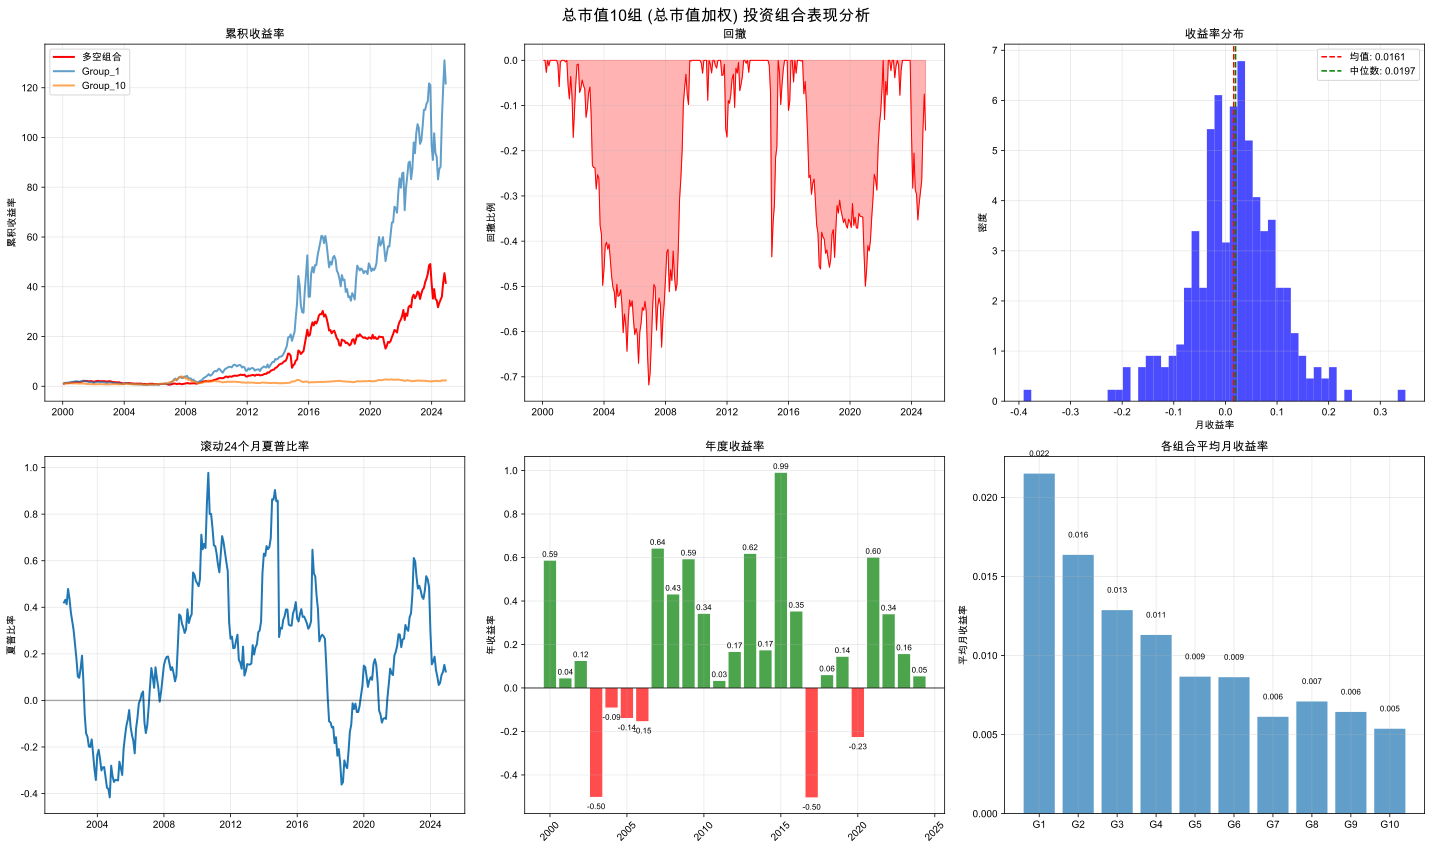

In [14]:
# 基于总市值的规模异象（指定时间范围）
print("=== 基于总市值(totalvalue)的规模异象 ===")
size_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'totalvalue', 
    n_groups=10, 
    ascending=True,
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2023年结束
)

size_stats_10 = analyze_portfolio_performance(
    size_portfolio_10, 
    "总市值10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)

# 反转 Reversal

=== 基于反转(ret)的规模异象 ===

总市值10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.008318    0.010076    0.009652    0.007861    0.010252    0.008616   
std      0.089881    0.086300    0.077900    0.077378    0.082145    0.080276   
min     -0.291110   -0.293801   -0.251438   -0.234399   -0.302977   -0.267823   
25%     -0.044501   -0.042083   -0.040480   -0.040641   -0.038553   -0.039539   
50%      0.006419    0.006411    0.007800    0.007215    0.008444    0.006693   
75%      0.051676    0.052669    0.052786    0.044296    0.049375    0.048251   
max      0.305230    0.322787    0.275616    0.307480    0.359032    0.285895   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.009099    0.007069    0.005602 

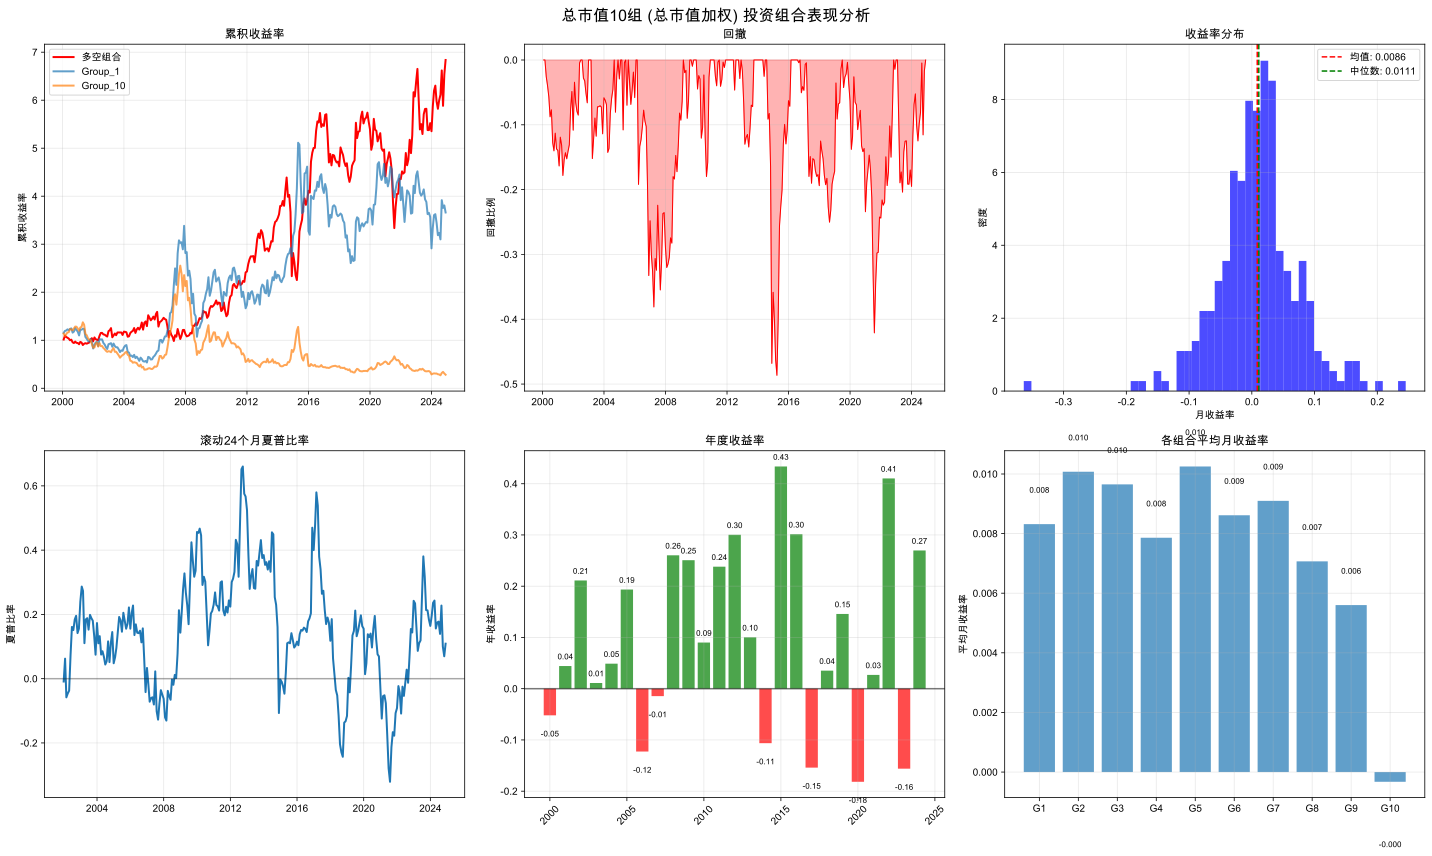

In [15]:
# 基于本月收益率的规模异象（指定时间范围）
print("=== 基于反转(ret)的规模异象 ===")
reversal_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'ret', 
    n_groups=10, 
    ascending=True,
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2023年结束
)

reversal_portfolio_10 = analyze_portfolio_performance(
    reversal_portfolio_10, 
    "总市值10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)

# 动量 Momentum

In [16]:
# 计算动量因子（t-1月到t-12月的累计收益率）
print("开始计算动量因子...")

# 首先为每个股票创建过去1-12个月的收益率列
for i in range(1, 13):  # t-1 到 t-12
    # 创建一个临时列，将月份向后移动i个月
    ret_mon[f'past_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'past_month_{i}'] = ret_mon[f'past_month_{i}'] - pd.DateOffset(months=i) + MonthEnd(0)
    
    # 使用merge来匹配过去月份的收益率
    past_returns = ret_mon[['Stkcd', 'month', 'ret']].copy()
    past_returns['month'] = past_returns['month'].dt.to_period('M').dt.to_timestamp('M')
    past_returns = past_returns.rename(
        columns={'month': f'past_month_{i}', 'ret': f'ret_t_minus_{i}'}
    )
    
    # 将过去收益率合并到原始数据中
    ret_mon = ret_mon.merge(
        past_returns,
        on=['Stkcd', f'past_month_{i}'],
        how='left'
    )
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'past_month_{i}'])

print("过去收益率列创建完成")

# 计算动量因子（t-1到t-12月的累计收益率）
momentum_cols = [f'ret_t_minus_{i}' for i in range(1, 13)]

def calculate_momentum(row):
    """计算单行的动量因子"""
    returns = []
    for col in momentum_cols:
        if pd.notna(row[col]):
            returns.append(row[col])
    
    # 至少需要6个月的数据
    if len(returns) >= 6:
        # 计算累计收益率: (1+r1)*(1+r2)*...*(1+rn) - 1
        momentum = np.prod([1 + r for r in returns]) - 1
        return momentum
    else:
        return np.nan

# 应用动量计算函数
ret_mon['momentum'] = ret_mon.apply(calculate_momentum, axis=1)

print("动量因子计算完成")
print(f"动量因子非空值数量: {ret_mon['momentum'].notna().sum()}")
print(f"总观测数: {len(ret_mon)}")
print(f"动量因子覆盖率: {ret_mon['momentum'].notna().sum() / len(ret_mon):.2%}")

print("\n动量因子描述性统计:")
print(ret_mon['momentum'].describe())

# 显示结果
ret_mon[['Stkcd', 'month', 'momentum'] + momentum_cols[:5]].head(20)

开始计算动量因子...
过去收益率列创建完成
动量因子计算完成
动量因子非空值数量: 668442
总观测数: 701288
动量因子覆盖率: 95.32%

动量因子描述性统计:
count    668442.000000
mean          0.113277
std           0.619892
min          -0.976849
25%          -0.239547
50%          -0.036274
75%           0.264994
max          18.157006
Name: momentum, dtype: float64


,Stkcd,month,momentum,ret_t_minus_1,ret_t_minus_2,ret_t_minus_3,ret_t_minus_4,ret_t_minus_5
0,000001,1992-04-30,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,1992-05-31,NaN,0.471835,NaN,NaN,NaN,NaN
2,000001,1992-06-30,NaN,0.167934,0.471835,NaN,NaN,NaN
3,000001,1992-07-31,NaN,-0.076888,0.167934,0.471835,NaN,NaN
4,000001,1992-08-31,NaN,0.079622,-0.076888,0.167934,0.471835,NaN
5,000001,1992-09-30,NaN,-0.101487,0.079622,-0.076888,0.167934,0.471835
6,000001,1992-10-31,0.654950,0.075120,-0.101487,0.079622,-0.076888,0.167934
7,000001,1992-11-30,0.472323,-0.110352,0.075120,-0.101487,0.079622,-0.076888
8,000001,1992-12-31,0.402544,-0.047394,-0.110352,0.075120,-0.101487,0.079622
9,000001,1993-01-31,0.621043,0.155788,-0.047394,-0.110352,0.075120,-0.101487


=== 基于动量(momentum)的规模异象 ===

动量10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.004671    0.004178    0.005746    0.007618    0.008044    0.006705   
std      0.083192    0.077629    0.076047    0.077368    0.079448    0.078043   
min     -0.317855   -0.301077   -0.284051   -0.257303   -0.274279   -0.291637   
25%     -0.041526   -0.037626   -0.032596   -0.037525   -0.041229   -0.038452   
50%      0.005175    0.005800    0.008639    0.006742    0.005929    0.005171   
75%      0.046353    0.041561    0.042172    0.047339    0.047599    0.043515   
max      0.317789    0.258500    0.305879    0.253727    0.288306    0.248119   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.005716    0.006650    0.007

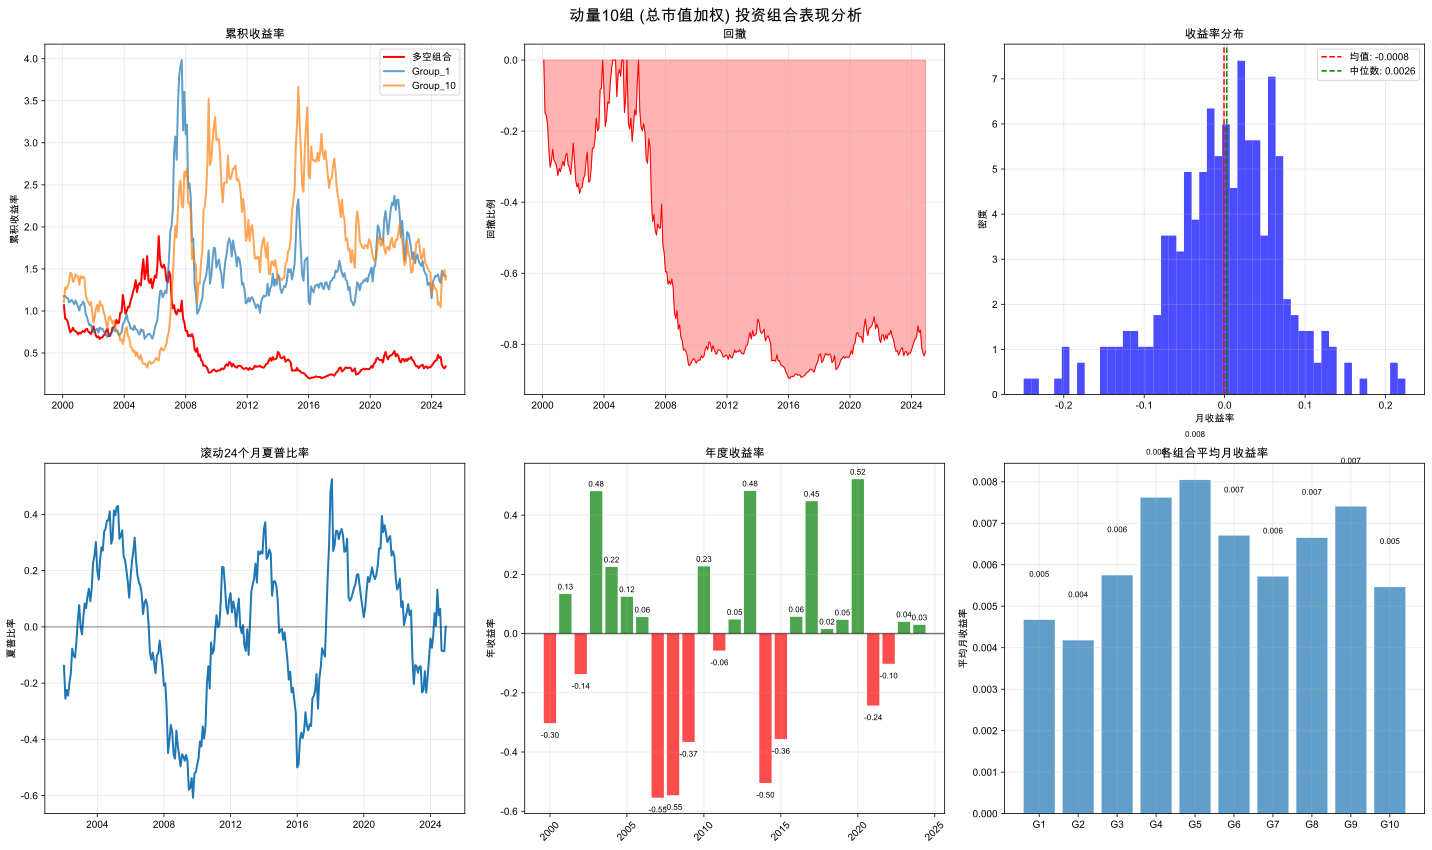

In [17]:
# 动量异象
print("=== 基于动量(momentum)的规模异象 ===")
momentum_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'momentum', 
    n_groups=10, 
    ascending=False,  # 动量因子是降序排列
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2024年结束
)

momentum_portfolio_10 = analyze_portfolio_performance(
    momentum_portfolio_10, 
    "动量10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)


# 非流动性

In [18]:
import os
import pandas as pd
from tqdm import tqdm

# 获取文件夹中所有的csv文件
csv_files = [f for f in os.listdir('/Volumes/BetaAlpha/Assetpricing/Input/Individual Return/Daily CSV') if f.endswith('.csv')]

# 创建进度条
pbar = tqdm(csv_files, desc="读取CSV文件", unit="文件")

# 读取所有csv文件并合并，显示详细进度
data_frames = []
for f in pbar:
    pbar.set_postfix(file=f)  # 显示当前正在读取的文件名
    df = pd.read_csv(os.path.join('/Volumes/BetaAlpha/Assetpricing/Input/Individual Return/Daily CSV', f))
    data_frames.append(df)
    
Ret_day = pd.concat(data_frames, ignore_index=True)
Ret_day.sort_values(by=['Stkcd', 'Trddt'])

# 补齐Stkcd为6位数字，前面补0
Ret_day['Stkcd'] = Ret_day['Stkcd'].astype(str).str.zfill(6)
# 转换日期列
Ret_day['Trddt'] = pd.to_datetime(Ret_day['Trddt'])
Ret_day['Capchgdt'] = pd.to_datetime(Ret_day['Capchgdt'])

# 生成月份和季度最后一天(Monthend)，并去掉小时分钟秒钟
Ret_day['month'] = Ret_day['Trddt'].dt.to_period('M').dt.end_time.dt.normalize()
Ret_day['quarter'] = Ret_day['Trddt'].dt.to_period('Q').dt.end_time.dt.normalize()

# 转换其他列为数值型
numeric_cols = Ret_day.columns.difference(['Stkcd', 'Trddt', 'Capchgdt', 'month', 'quarter'])
Ret_day[numeric_cols] = Ret_day[numeric_cols].apply(pd.to_numeric, errors='coerce')

Ret_day = Ret_day.rename(columns={'Trddt': "Day"})

Ret_day = Ret_day.sort_values(by = ['Stkcd','Day'])
# 市场类型 1 4 16
Ret_day = Ret_day[(Ret_day['Markettype'] == 1) | (Ret_day['Markettype'] == 4) | (Ret_day['Markettype'] == 16)]

# 交易状态 1 4 7 10 13
# 过滤交易状态为1(正常交易)、4(S股)、7(G股)、10(U股)、13(N股)的记录
Ret_day = Ret_day[(Ret_day['Trdsta'] == 1) | (Ret_day['Trdsta'] == 4) | 
                 (Ret_day['Trdsta'] == 7) | (Ret_day['Trdsta'] == 10) | 
                 (Ret_day['Trdsta'] == 13)]


读取CSV文件: 100%|██████████| 19/19 [00:13<00:00,  1.39文件/s, file=TRD_Dalyr2020_2024_1.csv]


,Stkcd,Trddt,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus
12671207,1,1991-04-03,49.00,49.00,49.00,49.00,100,5000.00,1298500.0,2376508.38,0.225000,0.225000,49.00,49.00,4,1991-04-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671208,1,1991-04-04,48.76,48.76,48.76,48.76,300,15000.00,1292140.0,2364868.34,-0.004898,-0.004898,48.76,48.76,4,1991-04-03,1,NaN,NaN,49.00,-0.004898,NaN,NaN,0.0
12671209,1,1991-04-05,48.52,48.52,48.52,48.52,200,10000.00,1285780.0,2353228.30,-0.004922,-0.004922,48.52,48.52,4,1991-04-03,1,NaN,NaN,48.76,-0.004922,NaN,NaN,0.0
12671210,1,1991-04-06,48.28,48.28,48.28,48.28,700,34000.00,1279420.0,2341588.26,-0.004946,-0.004946,48.28,48.28,4,1991-04-03,1,NaN,NaN,48.52,-0.004946,NaN,NaN,0.0
12671211,1,1991-04-08,48.04,48.04,48.04,48.04,200,10000.00,1273060.0,2329948.21,-0.004971,-0.004971,48.04,48.04,4,1991-04-03,1,NaN,NaN,48.28,-0.004971,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671202,920128,2024-12-25,31.70,31.70,29.66,29.72,1384408,42048224.14,508212.0,2332722.80,-0.053503,-0.053503,29.72,29.72,64,2024-11-29,1,0.0,0.0,31.40,-0.053503,21.98,40.82,0.0
10671203,920128,2024-12-26,29.85,31.00,29.80,30.29,1536760,46849880.35,517959.0,2377462.10,0.019179,0.019179,30.29,30.29,64,2024-11-29,1,0.0,0.0,29.72,0.019179,20.81,38.63,0.0
10671204,920128,2024-12-27,30.05,30.58,30.05,30.20,1025721,31075550.40,516420.0,2370398.00,-0.002971,-0.002971,30.20,30.20,64,2024-11-29,1,0.0,0.0,30.29,-0.002971,21.21,39.37,0.0
10671205,920128,2024-12-30,30.16,30.20,28.81,28.81,1484789,43487685.38,492651.0,2339083.90,-0.046026,-0.046026,28.81,28.81,64,2024-12-28,1,0.0,0.0,30.20,-0.046026,21.14,39.26,0.0


In [19]:
# 合并 risk free 
riskfree_day = riskfree[['Clsdt','Nrrdaydt']]
riskfree_day = riskfree_day.rename(columns = {'Clsdt': 'Day',
                                              'Nrrdaydt': 'rfday'})
# Day to dataime rfday to numetric
riskfree_day['Day'] = pd.to_datetime(riskfree_day['Day'])
riskfree_day['rfday'] = pd.to_numeric(riskfree_day['rfday'])

riskfree_day

,Day,rfday
0,1990-04-15,0.0263
1,1990-08-21,0.0227
2,1990-12-19,0.0227
3,1990-12-20,0.0227
4,1990-12-21,0.0227
...,...,...
12429,2024-12-27,0.0037
12430,2024-12-28,0.0037
12431,2024-12-29,0.0037
12432,2024-12-30,0.0037


In [20]:
Marketret_day_stock = pd.read_csv('Data/TRD_Cndalym2024.csv')
Marketret_day_stock = Marketret_day_stock[Marketret_day_stock['Markettype'] == 21]
Marketret_day_stock = Marketret_day_stock[['Trddt', 'Cdretwdos', 'Cdretwdeq']].dropna()
Marketret_day_stock.columns = ['Day', 'MarketR', 'MarketR_e']
Marketret_day_stock['Day'] = pd.to_datetime(Marketret_day_stock['Day'],format='%Y-%m-%d')
Marketret_day_stock

,Day,MarketR,MarketR_e
19,1990-12-20,0.050067,0.752547
36,1990-12-21,0.039671,67.771445
53,1990-12-24,0.049380,0.049638
70,1990-12-25,0.049938,0.050022
87,1990-12-26,0.050151,0.050151
...,...,...,...
158340,2024-12-25,-0.004361,-0.019226
158359,2024-12-26,0.002969,0.011729
158378,2024-12-27,0.002119,0.008489
158397,2024-12-30,0.000660,-0.008647


In [21]:
Ret_day = pd.merge(Ret_day,Marketret_day_stock,on='Day',how='left')
Ret_day = pd.merge(Ret_day,riskfree_day,on='Day',how='left')
Ret_day['ret'] = Ret_day['Dretwd'] - Ret_day['rfday']
Ret_day['ret_mkt'] = Ret_day['MarketR'] - Ret_day['rfday']
Ret_day

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,Dretwd,Dretnd,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,LimitDown,LimitUp,LimitStatus,month,quarter,MarketR,MarketR_e,rfday,ret,ret_mkt
0,000001,1991-04-03,49.00,49.00,49.00,49.00,100,5000.0,1298500.00,2376508.38,0.225000,0.225000,49.000000,49.000000,4,1991-04-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-04-30,1991-06-30,-0.000186,0.030412,0.0227,0.202300,-0.022886
1,000001,1991-04-04,48.76,48.76,48.76,48.76,300,15000.0,1292140.00,2364868.34,-0.004898,-0.004898,48.760000,48.760000,4,1991-04-03,1,NaN,NaN,49.00,-0.004898,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.005019,-0.005047,0.0227,-0.027598,-0.027719
2,000001,1991-04-05,48.52,48.52,48.52,48.52,200,10000.0,1285780.00,2353228.30,-0.004922,-0.004922,48.520000,48.520000,4,1991-04-03,1,NaN,NaN,48.76,-0.004922,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.003966,-0.003821,0.0227,-0.027622,-0.026666
3,000001,1991-04-06,48.28,48.28,48.28,48.28,700,34000.0,1279420.00,2341588.26,-0.004946,-0.004946,48.280000,48.280000,4,1991-04-03,1,NaN,NaN,48.52,-0.004946,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.004946,-0.004946,0.0227,-0.027646,-0.027646
4,000001,1991-04-08,48.04,48.04,48.04,48.04,200,10000.0,1273060.00,2329948.21,-0.004971,-0.004971,48.040000,48.040000,4,1991-04-03,1,NaN,NaN,48.28,-0.004971,NaN,NaN,0.0,1991-04-30,1991-06-30,-0.006276,-0.003938,0.0227,-0.027671,-0.028976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14662441,605599,2024-12-25,11.32,11.42,11.12,11.38,3357400,37892070.0,8851111.36,8851111.36,0.006189,0.006189,12.837053,11.379976,1,2024-09-09,1,0.0,0.0,11.31,0.006189,10.18,12.44,0.0,2024-12-31,2024-12-31,-0.004361,-0.019226,0.0037,0.002489,-0.008061
14662442,605599,2024-12-26,11.38,11.57,11.27,11.35,3268799,37208491.0,8827778.03,8827778.03,-0.002636,-0.002636,12.803212,11.349976,1,2024-09-09,1,0.0,0.0,11.38,-0.002636,10.24,12.52,0.0,2024-12-31,2024-12-31,0.002969,0.011729,0.0037,-0.006336,-0.000731
14662443,605599,2024-12-27,11.34,11.56,11.24,11.50,3191851,36510958.0,8944444.70,8944444.70,0.013216,0.013216,12.972417,11.499976,1,2024-09-09,1,0.0,0.0,11.35,0.013216,10.22,12.49,0.0,2024-12-31,2024-12-31,0.002119,0.008489,0.0037,0.009516,-0.001581
14662444,605599,2024-12-30,11.50,11.54,11.26,11.31,3091180,35133841.0,8796666.92,8796666.92,-0.016522,-0.016522,12.758090,11.309976,1,2024-09-09,1,0.0,0.0,11.50,-0.016522,10.35,12.65,0.0,2024-12-31,2024-12-31,0.000660,-0.008647,0.0037,-0.020222,-0.003040


## 计算Amihud 2002

In [31]:
# 计算Amihud 2002 非流动性指标
# 公式: ILLIQ = (1/Days) * Σ(|Return|/Volume)
# 其中 Return 是日收益率，Volume 是交易量

print("开始计算 Amihud 2002 非流动性指标...")

# 确保必要的列存在且为数值型
# 不考虑现金红利再投资的收益率 Dretnd
# 交易金额 Dnvaltrd
Ret_day['Dretnd'] = pd.to_numeric(Ret_day['Dretnd'], errors='coerce')
Ret_day['Dnvaltrd'] = pd.to_numeric(Ret_day['Dnvaltrd'], errors='coerce')

# 计算每日的 Amihud 非流动性度量
# 使用绝对收益率除以交易量（万股）
Ret_day['daily_illiq'] = abs(Ret_day['Dretnd']) / (Ret_day['Dnvaltrd'] / 10000)

# 处理无穷大和NaN值
Ret_day['daily_illiq'] = Ret_day['daily_illiq'].replace([np.inf, -np.inf], np.nan)

# 按股票和月份分组计算月度平均 Amihud 非流动性
print("按月份计算 Amihud 非流动性...")

# 计算每个股票每月的 Amihud 非流动性指标
amihud_monthly = Ret_day.groupby(['Stkcd', 'month']).agg({
    'daily_illiq': ['mean', 'count'],  # 平均值和观测数
    'Dretnd': 'count'  # 有效交易天数
}).reset_index()

# 简化列名
amihud_monthly.columns = ['Stkcd', 'month', 'amihud_illiq', 'valid_days', 'trading_days']

# 只保留有足够交易天数的观测值（至少5天）
amihud_monthly = amihud_monthly[amihud_monthly['valid_days'] >= 5]

# 添加到主要数据框中
ret_mon = ret_mon.merge(
    amihud_monthly[['Stkcd', 'month', 'amihud_illiq']], 
    on=['Stkcd', 'month'], 
    how='left'
)

print(f"Amihud 非流动性指标计算完成!")
print(f"成功计算的股票-月份观测数: {amihud_monthly.shape[0]}")
print(f"合并后的数据维度: {ret_mon.shape}")

# 显示 Amihud 非流动性指标的描述性统计
print("\n=== Amihud 非流动性指标描述性统计 ===")
print(ret_mon['amihud_illiq'].describe())

# 显示部分数据
print("\n=== 部分数据展示 ===")
print(ret_mon[['Stkcd', 'month', 'amihud_illiq', 'totalvalue', 'Return']].head(10))


开始计算 Amihud 2002 非流动性指标...
按月份计算 Amihud 非流动性...
Amihud 非流动性指标计算完成!
成功计算的股票-月份观测数: 735048
合并后的数据维度: (701288, 24)

=== Amihud 非流动性指标描述性统计 ===
count    6.726730e+05
mean     1.478381e-05
std      5.246949e-04
min      9.053114e-09
25%      1.479168e-06
50%      3.457757e-06
75%      8.746623e-06
max      3.737759e-01
Name: amihud_illiq, dtype: float64

=== 部分数据展示 ===
    Stkcd      month  amihud_illiq    totalvalue    Return
0  000001 1992-04-30      0.000013  5.185820e+09  0.477927
1  000001 1992-05-31      0.000007  6.088287e+09  0.174026
2  000001 1992-06-30      0.000012  5.657258e+09 -0.070796
3  000001 1992-07-31      0.000004  6.142166e+09  0.085714
4  000001 1992-08-31      0.000011  5.556236e+09 -0.095395
5  000001 1992-09-30      0.000005  6.007469e+09  0.081212
6  000001 1992-10-31      0.000007  5.381130e+09 -0.104260
7  000001 1992-11-30      0.000012  5.158881e+09 -0.041302
8  000001 1992-12-31      0.000005  5.994000e+09  0.161880
9  000001 1993-01-31      0.000003  6.58666

=== 基于 Amihud 非流动性指标的投资组合分析 ===
有效观测数: 672673

Amihud非流动性10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.015658    0.014419    0.013700    0.012161    0.008870    0.007978   
std      0.091212    0.089817    0.089649    0.089564    0.086047    0.085368   
min     -0.290512   -0.287331   -0.275678   -0.303666   -0.289758   -0.300552   
25%     -0.037700   -0.037012   -0.037483   -0.036190   -0.042177   -0.043599   
50%      0.012433    0.011314    0.010863    0.008342    0.005451    0.005717   
75%      0.063892    0.065157    0.059056    0.058548    0.054711    0.051236   
max      0.355605    0.311139    0.337962    0.290407    0.319620    0.299702   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.0

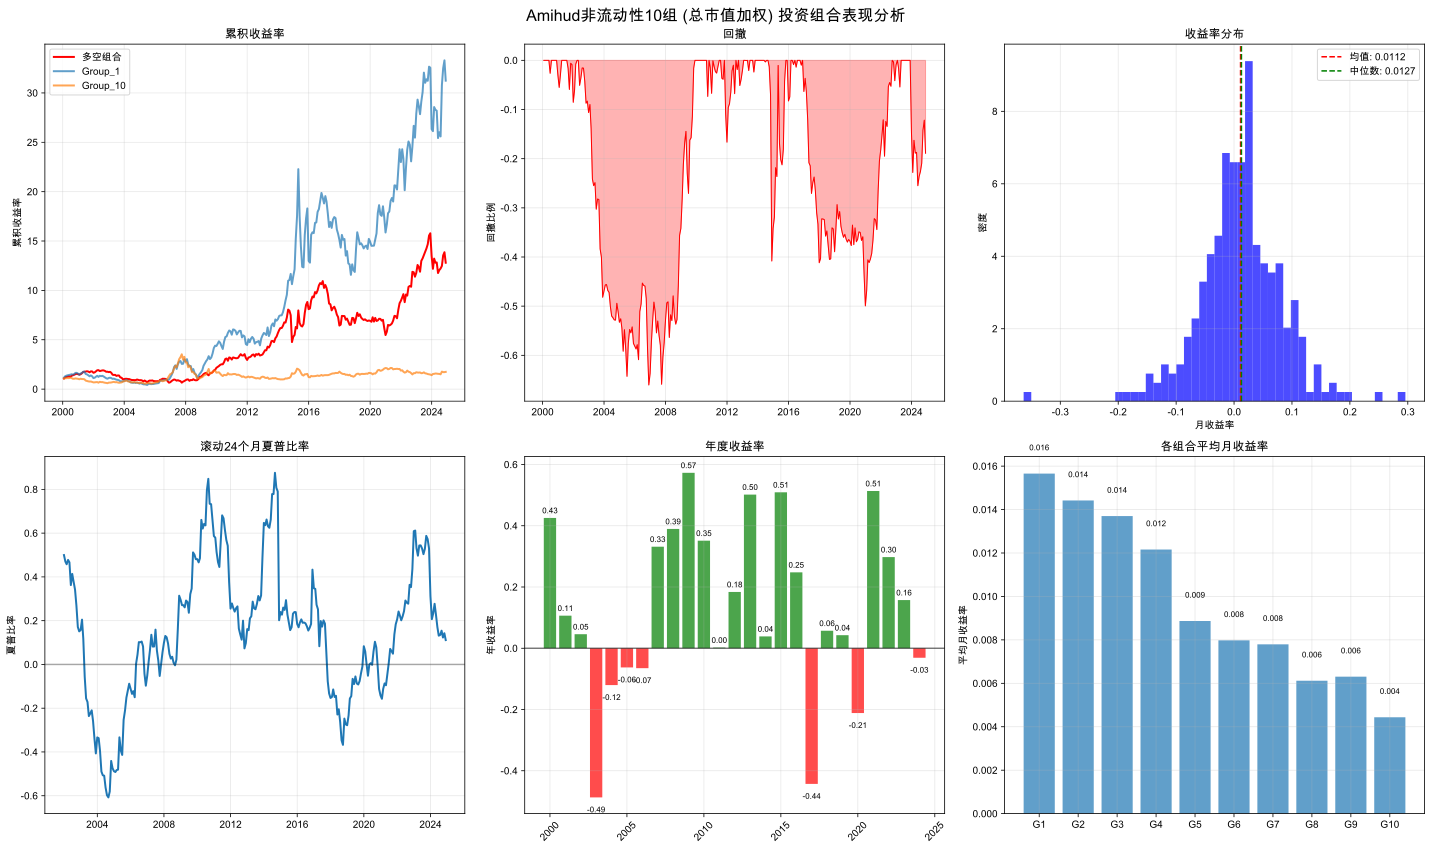

In [32]:
# 基于 Amihud 非流动性指标构建投资组合
print("=== 基于 Amihud 非流动性指标的投资组合分析 ===")

# 删除 Amihud 非流动性指标缺失的观测值
amihud_data = ret_mon.dropna(subset=['amihud_illiq'])
print(f"有效观测数: {len(amihud_data)}")

# 构建10分位数投资组合
# 注意：Amihud 指标越高，非流动性越强，因此使用升序排列
amihud_portfolio_10 = construct_anomaly_portfolio(
    amihud_data, 
    'amihud_illiq', 
    n_groups=10, 
    ascending=False,  # 非流动性指标升序排列：1组=最具流动性，10组=最不具流动性
    weight_method='totalvalue',
    start_date='2000-01-01',
    end_date='2024-12-31'
)

# 分析投资组合表现
amihud_analysis = analyze_portfolio_performance(
    amihud_portfolio_10, 
    "Amihud非流动性10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)


## 日内流动性

In [33]:
# 计算基于日内收益率的 Amihud 2002 非流动性指标
# 在您现有方法基础上的改进：使用日内收益率（收盘价/开盘价 - 1）作为分子

print("=== 计算基于日内收益率的 Amihud 非流动性指标 ===")

# 确保必要的列存在且为数值型
Ret_day['Opnprc'] = pd.to_numeric(Ret_day['Opnprc'], errors='coerce')
Ret_day['Clsprc'] = pd.to_numeric(Ret_day['Clsprc'], errors='coerce')
Ret_day['Dnvaltrd'] = pd.to_numeric(Ret_day['Dnvaltrd'], errors='coerce')

# 计算日内收益率：收盘价/开盘价 - 1
Ret_day['intraday_return'] = Ret_day['Clsprc'] / Ret_day['Opnprc'] - 1

# 计算基于日内收益率的每日 Amihud 非流动性度量
# 使用绝对日内收益率除以交易金额（万元）
Ret_day['daily_illiq_intraday'] = abs(Ret_day['intraday_return']) / (Ret_day['Dnvaltrd'] / 10000)

# 处理无穷大和NaN值
Ret_day['daily_illiq_intraday'] = Ret_day['daily_illiq_intraday'].replace([np.inf, -np.inf], np.nan)

print("按月份计算基于日内收益率的 Amihud 非流动性...")

# 计算每个股票每月的基于日内收益率的 Amihud 非流动性指标
amihud_intraday_monthly = Ret_day.groupby(['Stkcd', 'month']).agg({
    'daily_illiq_intraday': ['mean', 'count'],  # 平均值和观测数
    'intraday_return': 'count'  # 有效交易天数
}).reset_index()

# 简化列名
amihud_intraday_monthly.columns = ['Stkcd', 'month', 'amihud_intraday', 'valid_days_intraday', 'trading_days_intraday']

# 只保留有足够交易天数的观测值（至少5天）
amihud_intraday_monthly = amihud_intraday_monthly[amihud_intraday_monthly['valid_days_intraday'] >= 5]

# 添加到主要数据框中
ret_mon = ret_mon.merge(
    amihud_intraday_monthly[['Stkcd', 'month', 'amihud_intraday']], 
    on=['Stkcd', 'month'], 
    how='left'
)

print(f"基于日内收益率的 Amihud 非流动性指标计算完成!")
print(f"成功计算的股票-月份观测数: {amihud_intraday_monthly.shape[0]}")
print(f"合并后的数据维度: {ret_mon.shape}")

=== 计算基于日内收益率的 Amihud 非流动性指标 ===
按月份计算基于日内收益率的 Amihud 非流动性...
基于日内收益率的 Amihud 非流动性指标计算完成!
成功计算的股票-月份观测数: 735048
合并后的数据维度: (701288, 25)


=== 基于日内收益率 Amihud 非流动性指标的投资组合分析 ===
有效观测数: 672673

日内Amihud非流动性10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.018633    0.016229    0.013644    0.011400    0.009944    0.007855   
std      0.091702    0.090461    0.089414    0.088387    0.086901    0.084267   
min     -0.277588   -0.281134   -0.287101   -0.307607   -0.291185   -0.289163   
25%     -0.031363   -0.036186   -0.035689   -0.034521   -0.039510   -0.043995   
50%      0.014296    0.014148    0.011237    0.009051    0.006505    0.006712   
75%      0.065388    0.064992    0.060761    0.057123    0.054419    0.050732   
max      0.375118    0.321976    0.323981    0.293796    0.320863    0.289570   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean 

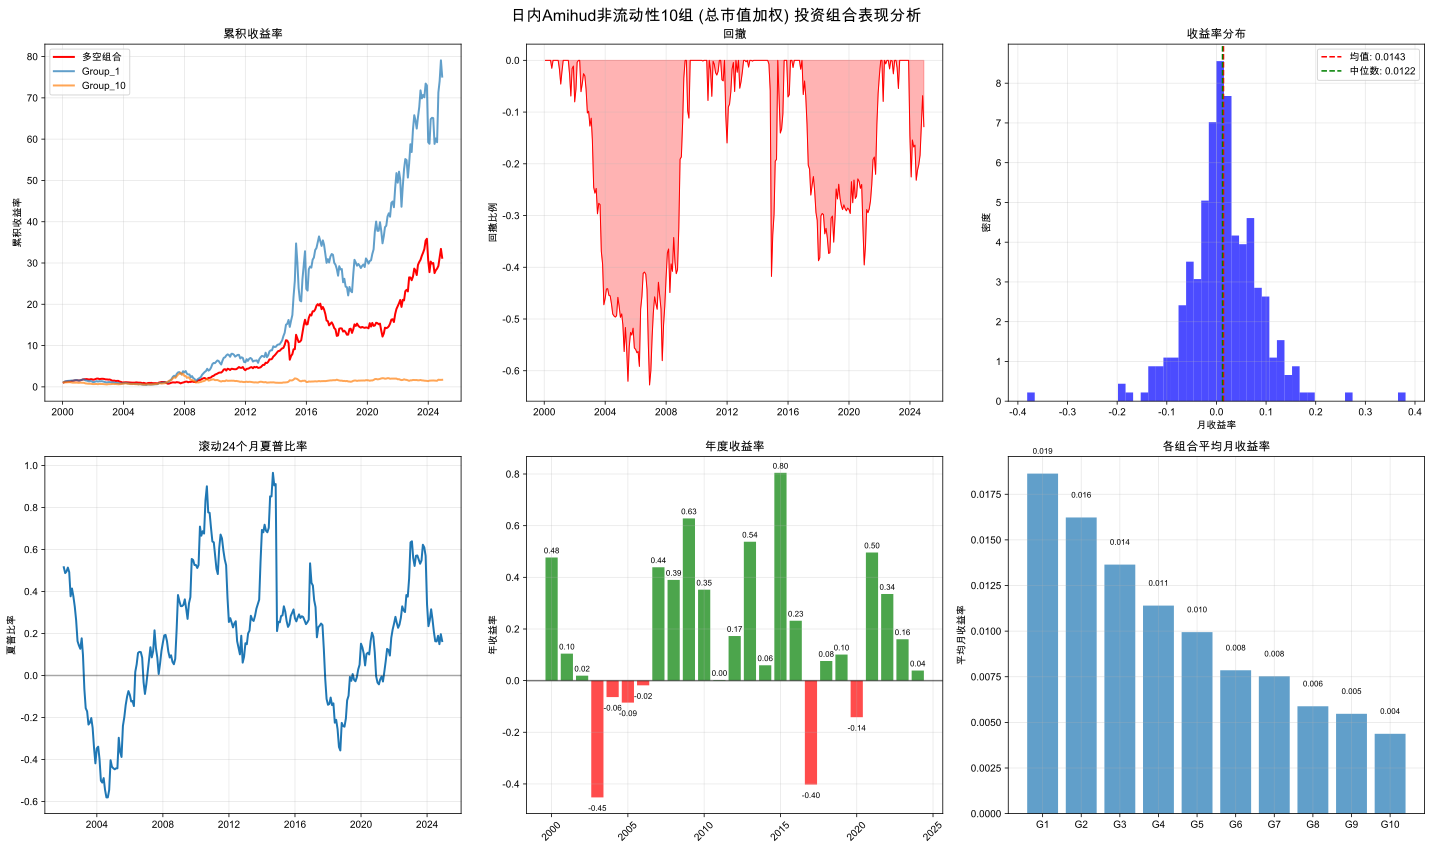

In [35]:
# 基于日内收益率 Amihud 非流动性指标构建投资组合
print("=== 基于日内收益率 Amihud 非流动性指标的投资组合分析 ===")

# 删除日内 Amihud 非流动性指标缺失的观测值
amihud_intraday_data = ret_mon.dropna(subset=['amihud_intraday'])
print(f"有效观测数: {len(amihud_intraday_data)}")

# 构建10分位数投资组合
# 注意：Amihud 指标越高，非流动性越强，因此第1组是流动性最好的
amihud_intraday_portfolio_10 = construct_anomaly_portfolio(
    amihud_intraday_data, 
    'amihud_intraday', 
    n_groups=10, 
    ascending=False,  # 升序排列：1组=最具流动性，10组=最不具流动性
    weight_method='totalvalue',
    start_date='2000-01-01',
    end_date='2024-12-31'
)

# 分析投资组合表现
amihud_intraday_analysis = analyze_portfolio_performance(
    amihud_intraday_portfolio_10, 
    "日内Amihud非流动性10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)

# 双重分组

In [40]:
def double_sort_portfolio_analysis(data, primary_var, secondary_var, 
                                 primary_groups=3, secondary_groups=10,
                                 future_return_col='ret_t1', 
                                 weight_method='totalvalue',
                                 start_date=None, end_date=None,
                                 primary_ascending=True, secondary_ascending=True,
                                 min_stocks=5):
    """
    双重分组投资组合分析函数（修复警告版本）
    
    参数:
    data: DataFrame, 包含股票数据
    primary_var: str, 第一个分组变量名（控制变量，分3组）
    secondary_var: str, 第二个分组变量名（测试变量，分10组）
    primary_groups: int, 第一个变量分组数，默认3组
    secondary_groups: int, 第二个变量分组数，默认10组
    future_return_col: str, 未来收益率列名
    weight_method: str, 加权方法 ('totalvalue', 'floatingvalue', 'equal')
    start_date: str, 样本起始时间
    end_date: str, 样本结束时间
    primary_ascending: bool, 第一个变量排序方向
    secondary_ascending: bool, 第二个变量排序方向
    min_stocks: int, 每个组合最少股票数
    
    返回:
    results: dict, 包含所有分析结果
    """
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    from statsmodels.stats.sandwich_covariance import cov_hac
    
    print(f"=== 双重分组分析：{primary_var} ({primary_groups}组) vs {secondary_var} ({secondary_groups}组) ===")
    
    # 数据预处理 - 创建明确的副本
    analysis_data = data.copy()
    
    # 时间筛选
    if start_date:
        start_date = pd.to_datetime(start_date)
        analysis_data = analysis_data[analysis_data['month'] >= start_date].copy()
    if end_date:
        end_date = pd.to_datetime(end_date)
        analysis_data = analysis_data[analysis_data['month'] <= end_date].copy()
    
    # 删除缺失值
    required_cols = [primary_var, secondary_var, future_return_col]
    if weight_method in ['totalvalue', 'floatingvalue']:
        required_cols.append(weight_method)
    
    analysis_data = analysis_data.dropna(subset=required_cols).copy()
    print(f"有效观测数: {len(analysis_data)}")
    
    # 存储结果
    portfolio_returns = {}
    monthly_results = []
    
    # 获取所有月份
    months = sorted(analysis_data['month'].unique())
    
    for month in months:
        # 创建月度数据的副本
        month_data = analysis_data[analysis_data['month'] == month].copy()
        
        if len(month_data) < primary_groups * secondary_groups * min_stocks:
            continue
        
        # 第一步：按第一个变量分组
        try:
            month_data.loc[:, 'primary_rank'] = pd.qcut(month_data[primary_var], 
                                                       q=primary_groups, 
                                                       labels=False, 
                                                       duplicates='drop')
        except ValueError:
            month_data.loc[:, 'primary_rank'] = pd.qcut(month_data[primary_var].rank(method='first'), 
                                                       q=primary_groups, 
                                                       labels=False)
        
        if not primary_ascending:
            month_data.loc[:, 'primary_rank'] = primary_groups - 1 - month_data['primary_rank']
        
        # 第二步：在每个主要组内按第二个变量分组
        month_portfolios = {}
        
        for primary_group in range(primary_groups):
            # 创建明确的副本
            primary_data = month_data[month_data['primary_rank'] == primary_group].copy()
            
            if len(primary_data) < secondary_groups * min_stocks:
                continue
            
            # 在主要组内按次要变量分组
            try:
                primary_data.loc[:, 'secondary_rank'] = pd.qcut(primary_data[secondary_var], 
                                                               q=secondary_groups, 
                                                               labels=False, 
                                                               duplicates='drop')
            except ValueError:
                primary_data.loc[:, 'secondary_rank'] = pd.qcut(primary_data[secondary_var].rank(method='first'), 
                                                               q=secondary_groups, 
                                                               labels=False)
            
            if not secondary_ascending:
                primary_data.loc[:, 'secondary_rank'] = secondary_groups - 1 - primary_data['secondary_rank']
            
            # 计算每个子组的加权收益率
            for secondary_group in range(secondary_groups):
                group_data = primary_data[primary_data['secondary_rank'] == secondary_group].copy()
                
                if len(group_data) >= min_stocks:
                    if weight_method == 'equal':
                        weighted_return = group_data[future_return_col].mean()
                    else:
                        weights = group_data[weight_method]
                        total_weight = weights.sum()
                        if total_weight > 0:
                            weighted_return = (group_data[future_return_col] * weights).sum() / total_weight
                        else:
                            weighted_return = np.nan
                    
                    portfolio_name = f'P{primary_group+1}_S{secondary_group+1}'
                    month_portfolios[portfolio_name] = weighted_return
            
            # 计算主要组内的多空组合
            if f'P{primary_group+1}_S1' in month_portfolios and f'P{primary_group+1}_S{secondary_groups}' in month_portfolios:
                long_short_name = f'P{primary_group+1}_LS'
                month_portfolios[long_short_name] = (month_portfolios[f'P{primary_group+1}_S1'] - 
                                                   month_portfolios[f'P{primary_group+1}_S{secondary_groups}'])
        
        # 存储该月的结果
        month_portfolios['month'] = month
        monthly_results.append(month_portfolios)
    
    # 转换为DataFrame
    results_df = pd.DataFrame(monthly_results)
    results_df = results_df.set_index('month').sort_index()
    
    # 分析结果
    analysis_results = {}
    
    # 1. 各组合的基本统计
    print("\n=== 各组合基本统计 ===")
    portfolio_stats = {}
    
    for primary_group in range(primary_groups):
        print(f"\n--- 第{primary_group+1}组 ({primary_var}) ---")
        group_cols = [f'P{primary_group+1}_S{i+1}' for i in range(secondary_groups)]
        group_cols = [col for col in group_cols if col in results_df.columns]
        
        if group_cols:
            group_stats = results_df[group_cols].describe()
            print(group_stats.round(4))
            portfolio_stats[f'Group_{primary_group+1}'] = group_stats
    
    # 2. 多空组合分析
    print("\n=== 多空组合分析 ===")
    ls_analysis = {}
    
    for primary_group in range(primary_groups):
        ls_col = f'P{primary_group+1}_LS'
        if ls_col in results_df.columns:
            ls_returns = results_df[ls_col].dropna()
            
            if len(ls_returns) > 0:
                # 基本统计
                mean_ret = ls_returns.mean()
                annual_ret = mean_ret * 12
                annual_vol = ls_returns.std() * np.sqrt(12)
                sharpe = annual_ret / annual_vol if annual_vol > 0 else np.nan
                
                # t统计量
                t_stat = mean_ret / (ls_returns.std() / np.sqrt(len(ls_returns)))
                
                # Newey-West t统计量
                try:
                    X = np.ones((len(ls_returns), 1))
                    y = ls_returns.values.reshape(-1, 1)
                    model = sm.OLS(y, X)
                    results = model.fit()
                    max_lags = int(np.floor(4 * (len(ls_returns) / 100) ** (2/9)))
                    max_lags = max(1, min(max_lags, len(ls_returns) // 4))
                    nw_cov = cov_hac(results, nlags=max_lags)
                    nw_se = np.sqrt(nw_cov[0, 0])
                    nw_t_stat = mean_ret / nw_se
                except:
                    nw_t_stat = t_stat
                
                ls_analysis[f'Group_{primary_group+1}'] = {
                    'mean_return': mean_ret,
                    'annual_return': annual_ret,
                    'annual_volatility': annual_vol,
                    'sharpe_ratio': sharpe,
                    't_stat': t_stat,
                    'nw_t_stat': nw_t_stat,
                    'observations': len(ls_returns)
                }
                
                print(f"第{primary_group+1}组多空组合:")
                print(f"  月均收益: {mean_ret:.4f} ({mean_ret*100:.2f}%)")
                print(f"  年化收益: {annual_ret:.4f} ({annual_ret*100:.2f}%)")
                print(f"  年化波动: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
                print(f"  夏普比率: {sharpe:.4f}")
                print(f"  t统计量: {t_stat:.4f}")
                print(f"  NW t统计量: {nw_t_stat:.4f}")
                print(f"  观测数: {len(ls_returns)}")
    
    # 3. 可视化分析
    plt.figure(figsize=(16, 12))
    
    # 子图1：各组合平均收益率热力图
    plt.subplot(2, 3, 1)
    heatmap_data = np.full((primary_groups, secondary_groups), np.nan)
    
    for i in range(primary_groups):
        for j in range(secondary_groups):
            col_name = f'P{i+1}_S{j+1}'
            if col_name in results_df.columns:
                heatmap_data[i, j] = results_df[col_name].mean()
    
    im = plt.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    plt.colorbar(im)
    plt.title(f'平均月收益率热力图\n行:{primary_var}, 列:{secondary_var}')
    plt.xlabel(f'{secondary_var} 分组')
    plt.ylabel(f'{primary_var} 分组')
    plt.xticks(range(secondary_groups), [f'S{i+1}' for i in range(secondary_groups)])
    plt.yticks(range(primary_groups), [f'P{i+1}' for i in range(primary_groups)])
    
    # 在热力图上添加数值
    for i in range(primary_groups):
        for j in range(secondary_groups):
            if not np.isnan(heatmap_data[i, j]):
                plt.text(j, i, f'{heatmap_data[i, j]:.3f}', 
                        ha='center', va='center', fontsize=8)
    
    # 子图2：多空组合累计收益率
    plt.subplot(2, 3, 2)
    for primary_group in range(primary_groups):
        ls_col = f'P{primary_group+1}_LS'
        if ls_col in results_df.columns:
            ls_returns = results_df[ls_col].dropna()
            if len(ls_returns) > 0:
                cum_returns = (1 + ls_returns).cumprod()
                plt.plot(cum_returns.index, cum_returns, 
                        label=f'{primary_var} 第{primary_group+1}组', linewidth=2)
    
    plt.title('多空组合累计收益率')
    plt.xlabel('时间')
    plt.ylabel('累计收益率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3：多空组合年化收益率对比
    plt.subplot(2, 3, 3)
    group_names = []
    annual_returns = []
    
    for primary_group in range(primary_groups):
        if f'Group_{primary_group+1}' in ls_analysis:
            group_names.append(f'第{primary_group+1}组')
            annual_returns.append(ls_analysis[f'Group_{primary_group+1}']['annual_return'])
    
    if annual_returns:
        bars = plt.bar(group_names, annual_returns)
        plt.title(f'{secondary_var} 多空组合年化收益率')
        plt.ylabel('年化收益率')
        plt.xticks(rotation=45)
        
        # 在柱子上添加数值
        for bar, ret in zip(bars, annual_returns):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{ret:.2%}', ha='center', va='bottom')
    
    # 子图4：多空组合夏普比率对比
    plt.subplot(2, 3, 4)
    sharpe_ratios = []
    
    for primary_group in range(primary_groups):
        if f'Group_{primary_group+1}' in ls_analysis:
            sharpe_ratios.append(ls_analysis[f'Group_{primary_group+1}']['sharpe_ratio'])
    
    if sharpe_ratios:
        bars = plt.bar(group_names, sharpe_ratios)
        plt.title(f'{secondary_var} 多空组合夏普比率')
        plt.ylabel('夏普比率')
        plt.xticks(rotation=45)
        
        for bar, sharpe in zip(bars, sharpe_ratios):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{sharpe:.3f}', ha='center', va='bottom')
    
    # 子图5：t统计量对比
    plt.subplot(2, 3, 5)
    t_stats = []
    nw_t_stats = []
    
    for primary_group in range(primary_groups):
        if f'Group_{primary_group+1}' in ls_analysis:
            t_stats.append(ls_analysis[f'Group_{primary_group+1}']['t_stat'])
            nw_t_stats.append(ls_analysis[f'Group_{primary_group+1}']['nw_t_stat'])
    
    if t_stats:
        x = np.arange(len(group_names))
        width = 0.35
        
        plt.bar(x - width/2, t_stats, width, label='传统t统计量')
        plt.bar(x + width/2, nw_t_stats, width, label='Newey-West t统计量')
        
        plt.axhline(y=1.96, color='red', linestyle='--', alpha=0.7, label='5%显著性水平')
        plt.axhline(y=-1.96, color='red', linestyle='--', alpha=0.7)
        
        plt.title(f'{secondary_var} 多空组合t统计量')
        plt.ylabel('t统计量')
        plt.xticks(x, group_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 子图6：收益率分布箱线图
    plt.subplot(2, 3, 6)
    ls_data_for_box = []
    ls_labels = []
    
    for primary_group in range(primary_groups):
        ls_col = f'P{primary_group+1}_LS'
        if ls_col in results_df.columns:
            ls_returns = results_df[ls_col].dropna()
            if len(ls_returns) > 0:
                ls_data_for_box.append(ls_returns)
                ls_labels.append(f'第{primary_group+1}组')
    
    if ls_data_for_box:
        plt.boxplot(ls_data_for_box, labels=ls_labels)
        plt.title(f'{secondary_var} 多空组合收益率分布')
        plt.ylabel('月收益率')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. 汇总表格
    print("\n=== 多空组合表现汇总表 ===")
    if ls_analysis:
        summary_df = pd.DataFrame(ls_analysis).T
        summary_df = summary_df.round(4)
        print(summary_df)
    
    # 返回结果
    return {
        'portfolio_returns': results_df,
        'portfolio_stats': portfolio_stats,
        'long_short_analysis': ls_analysis,
        'summary_table': summary_df if ls_analysis else None
    }

=== 示例1: 控制市值规模，检验 Amihud 非流动性异象 ===
=== 双重分组分析：totalvalue (3组) vs amihud_illiq (10组) ===
有效观测数: 636932

=== 各组合基本统计 ===

--- 第1组 (totalvalue) ---
          P1_S1     P1_S2     P1_S3     P1_S4     P1_S5     P1_S6     P1_S7  \
count  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000   
mean     0.0225    0.0231    0.0217    0.0179    0.0181    0.0182    0.0153   
std      0.1010    0.0993    0.1004    0.1006    0.0969    0.1018    0.0997   
min     -0.3197   -0.2758   -0.2981   -0.3029   -0.3068   -0.3111   -0.3265   
25%     -0.0398   -0.0361   -0.0384   -0.0374   -0.0396   -0.0385   -0.0414   
50%      0.0158    0.0188    0.0179    0.0119    0.0135    0.0125    0.0137   
75%      0.0747    0.0769    0.0706    0.0711    0.0716    0.0732    0.0696   
max      0.3930    0.3949    0.4118    0.3987    0.3548    0.3917    0.3427   

          P1_S8     P1_S9    P1_S10  
count  299.0000  299.0000  299.0000  
mean     0.0130    0.0102    0.0002  
std      0.1007    0.0999  

/var/folders/2c/bzxy6cc102b12rngr422_89h0000gn/T/ipykernel_69325/2114987756.py:335: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ls_data_for_box, labels=ls_labels)


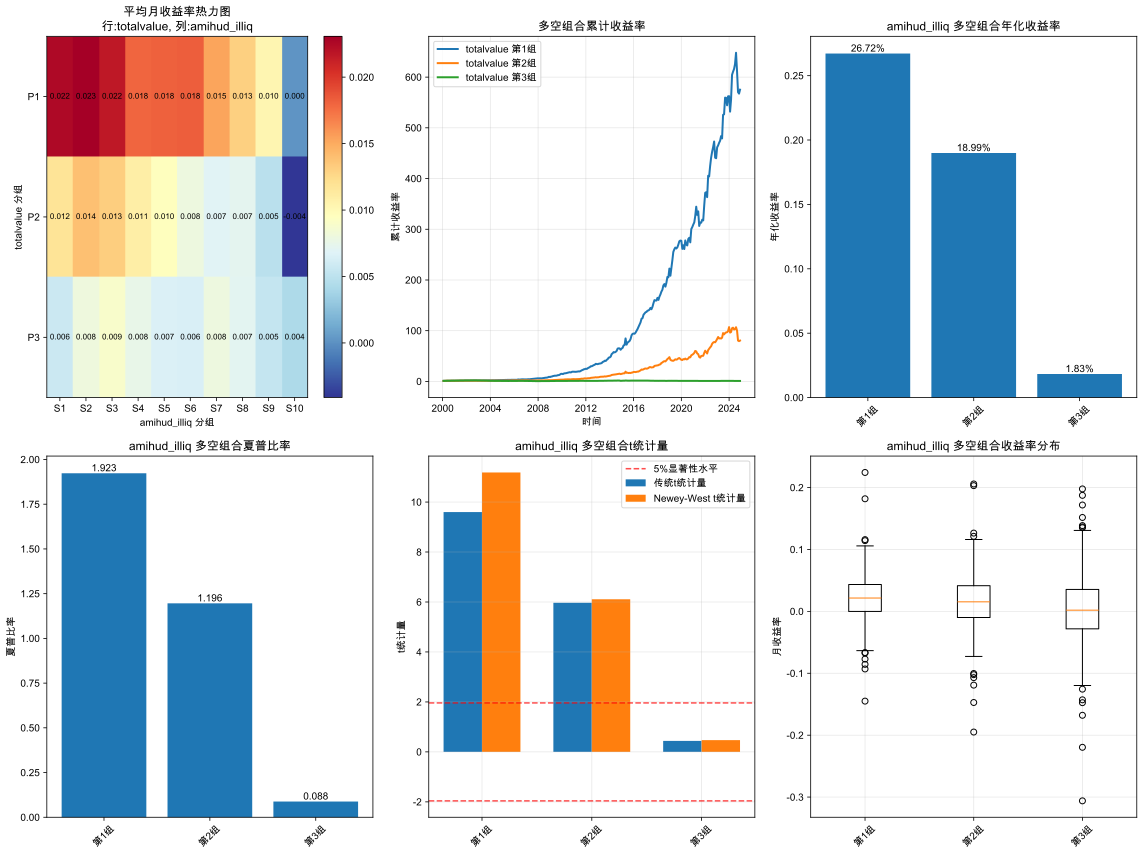


=== 多空组合表现汇总表 ===
         mean_return  annual_return  annual_volatility  sharpe_ratio  t_stat  \
Group_1       0.0223         0.2672             0.1389        1.9230  9.5990   
Group_2       0.0158         0.1899             0.1588        1.1957  5.9687   
Group_3       0.0015         0.0183             0.2076        0.0881  0.4398   

         nw_t_stat  observations  
Group_1    11.1838         299.0  
Group_2     6.1084         299.0  
Group_3     0.4704         299.0  
分析完成！结果已保存在 size_amihud_results 中


In [41]:
# 示例1: 控制市值规模，检验 Amihud 非流动性异象
print("=== 示例1: 控制市值规模，检验 Amihud 非流动性异象 ===")

# 确保有必要的数据
if 'totalvalue' in ret_mon.columns and 'amihud_illiq' in ret_mon.columns:
    
    # 执行双重分组分析
    size_amihud_results = double_sort_portfolio_analysis(
        data=ret_mon,
        primary_var='totalvalue',           # 第一个变量：市值规模（控制变量）
        secondary_var='amihud_illiq',       # 第二个变量：Amihud 非流动性（测试变量）
        primary_groups=3,                   # 市值分3组（小、中、大）
        secondary_groups=10,                # Amihud 分10组
        future_return_col='ret_t1',         # 未来1个月收益率
        weight_method='totalvalue',         # 总市值加权
        start_date='2000-01-01',
        end_date='2024-12-31',
        primary_ascending=True,             # 市值升序（1组=小市值，3组=大市值）
        secondary_ascending=False,           # Amihud 升序（1组=高流动性，10组=低流动性）
        min_stocks=5                        # 每组最少5只股票
    )
    
    print("分析完成！结果已保存在 size_amihud_results 中")
    
else:
    print("缺少必要的数据列，请先计算市值和 Amihud 指标")

=== 示例2: 控制市值规模，检验反转异象 ===
=== 双重分组分析：totalvalue (3组) vs ret (10组) ===
有效观测数: 664345

=== 各组合基本统计 ===

--- 第1组 (totalvalue) ---
          P1_S1     P1_S2     P1_S3     P1_S4     P1_S5     P1_S6     P1_S7  \
count  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000   
mean     0.0185    0.0213    0.0220    0.0197    0.0205    0.0173    0.0169   
std      0.1088    0.1036    0.1011    0.1013    0.0995    0.0996    0.0987   
min     -0.3089   -0.3107   -0.2897   -0.2889   -0.3001   -0.3225   -0.3061   
25%     -0.0473   -0.0366   -0.0366   -0.0373   -0.0388   -0.0389   -0.0407   
50%      0.0168    0.0132    0.0157    0.0168    0.0164    0.0145    0.0182   
75%      0.0830    0.0774    0.0736    0.0743    0.0772    0.0724    0.0756   
max      0.3885    0.3568    0.3934    0.4147    0.3735    0.3224    0.3237   

          P1_S8     P1_S9    P1_S10  
count  299.0000  299.0000  299.0000  
mean     0.0139    0.0079   -0.0004  
std      0.1013    0.0975    0.0993  
min     

/var/folders/2c/bzxy6cc102b12rngr422_89h0000gn/T/ipykernel_69325/2114987756.py:335: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ls_data_for_box, labels=ls_labels)


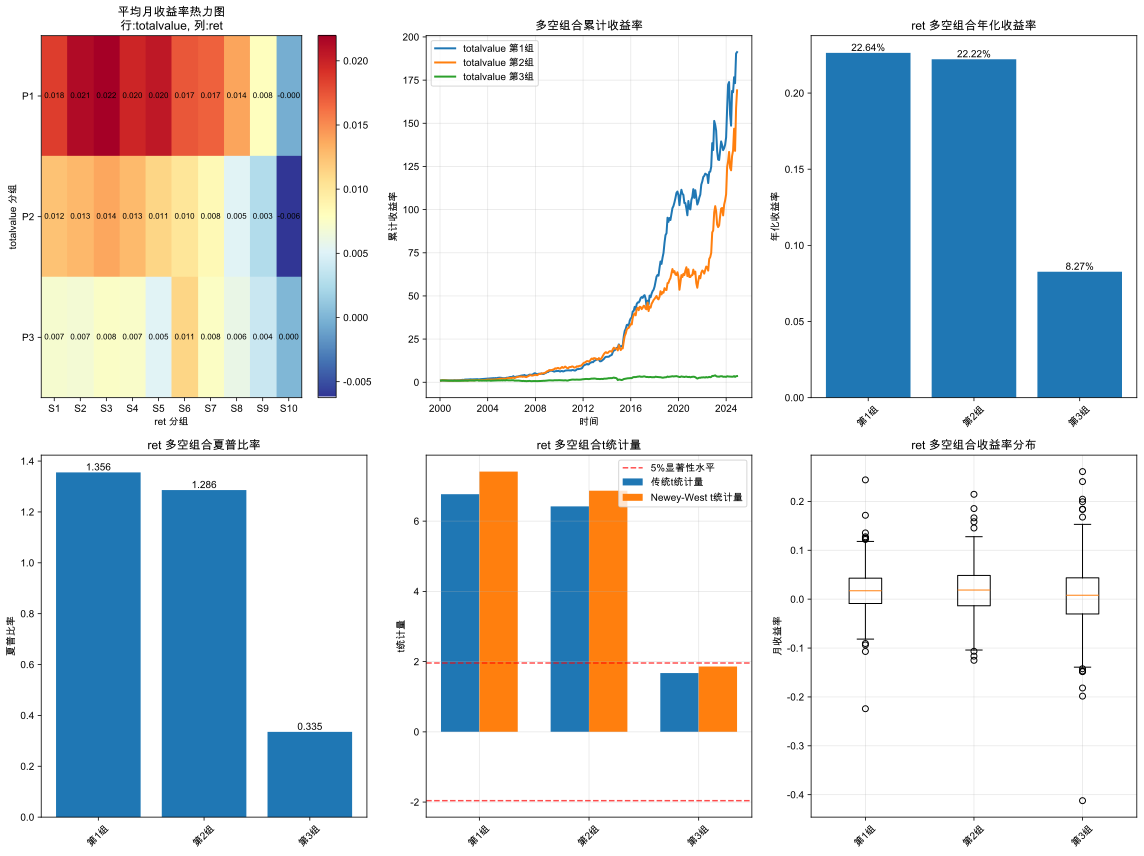


=== 多空组合表现汇总表 ===
         mean_return  annual_return  annual_volatility  sharpe_ratio  t_stat  \
Group_1       0.0189         0.2264             0.1670        1.3556  6.7669   
Group_2       0.0185         0.2222             0.1728        1.2862  6.4201   
Group_3       0.0069         0.0827             0.2466        0.3353  1.6737   

         nw_t_stat  observations  
Group_1     7.4109         299.0  
Group_2     6.8666         299.0  
Group_3     1.8603         299.0  
反转异象双重分组分析完成！


In [43]:
# 示例2: 控制市值规模，检验动量异象
print("=== 示例2: 控制市值规模，检验反转异象 ===")

if 'totalvalue' in ret_mon.columns and 'ret' in ret_mon.columns:
    
    size_momentum_results = double_sort_portfolio_analysis(
        data=ret_mon,
        primary_var='totalvalue',           # 控制变量：市值规模
        secondary_var='ret',           # 测试变量：反转因子
        primary_groups=3,
        secondary_groups=10,
        future_return_col='ret_t1',
        weight_method='totalvalue',
        start_date='2000-01-01',
        end_date='2024-12-31',
        primary_ascending=True,             # 市值升序
        secondary_ascending=True,          # 反转升序（1组=高反转，10组=低反转）
        min_stocks=5
    )
    
    print("反转异象双重分组分析完成！")
    
else:
    print("缺少反转因子数据")

=== 示例3: 控制 规模 流动性，检验非流动性效应 ===
=== 双重分组分析：totalvalue (3组) vs amihud_intraday (10组) ===
有效观测数: 636932

=== 各组合基本统计 ===

--- 第1组 (totalvalue) ---
          P1_S1     P1_S2     P1_S3     P1_S4     P1_S5     P1_S6     P1_S7  \
count  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000  299.0000   
mean     0.0246    0.0223    0.0218    0.0201    0.0177    0.0172    0.0146   
std      0.1016    0.0994    0.0996    0.1003    0.1009    0.0983    0.1003   
min     -0.3127   -0.2817   -0.2938   -0.3126   -0.3152   -0.3089   -0.3236   
25%     -0.0365   -0.0364   -0.0347   -0.0403   -0.0397   -0.0374   -0.0411   
50%      0.0173    0.0212    0.0179    0.0160    0.0113    0.0120    0.0137   
75%      0.0763    0.0742    0.0736    0.0766    0.0723    0.0689    0.0701   
max      0.4090    0.4089    0.3786    0.4010    0.3626    0.3615    0.3681   

          P1_S8     P1_S9    P1_S10  
count  299.0000  299.0000  299.0000  
mean     0.0135    0.0095   -0.0004  
std      0.1005    0.1002    

/var/folders/2c/bzxy6cc102b12rngr422_89h0000gn/T/ipykernel_69325/2114987756.py:335: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ls_data_for_box, labels=ls_labels)


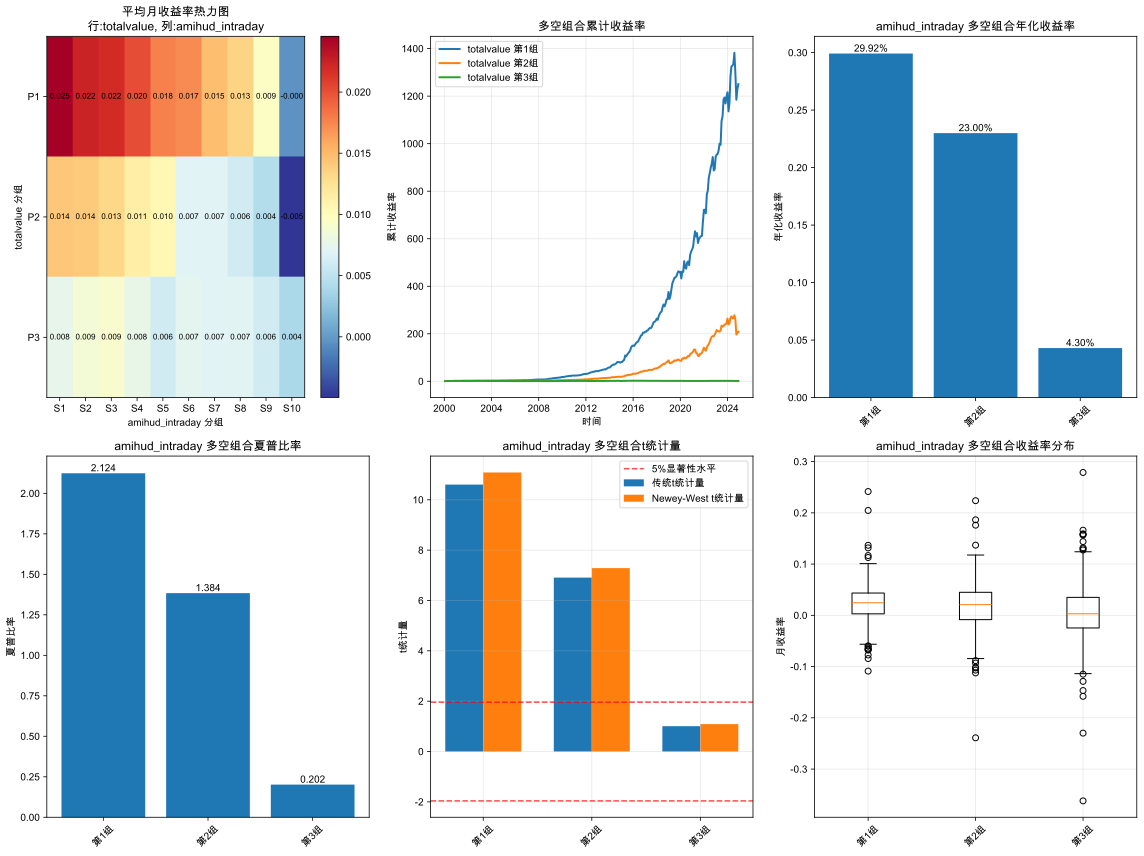


=== 多空组合表现汇总表 ===
         mean_return  annual_return  annual_volatility  sharpe_ratio   t_stat  \
Group_1       0.0249         0.2992             0.1408        2.1241  10.6027   
Group_2       0.0192         0.2300             0.1661        1.3841   6.9088   
Group_3       0.0036         0.0430             0.2134        0.2016   1.0063   

         nw_t_stat  observations  
Group_1    11.0850         299.0  
Group_2     7.2855         299.0  
Group_3     1.0891         299.0  
市值效应双重分组分析完成！


In [44]:
# 示例3: 控制 规模 流动性，检验非流动性效应
print("=== 示例3: 控制 规模 流动性，检验非流动性效应 ===")

if 'amihud_illiq' in ret_mon.columns and 'totalvalue' in ret_mon.columns:
    
    amihud_size_results = double_sort_portfolio_analysis(
        data=ret_mon,
        primary_var='totalvalue',         # 控制变量：流动性
        secondary_var='amihud_intraday',         # 测试变量：市值规模
        primary_groups=3,                   # 流动性分3组
        secondary_groups=10,                # 市值分10组
        future_return_col='ret_t1',
        weight_method='totalvalue',
        start_date='2000-01-01',
        end_date='2024-12-31',
        primary_ascending=True,             # 流动性升序（1组=高流动性，3组=低流动性）
        secondary_ascending=False,           # 市值升序（1组=小市值，10组=大市值）
        min_stocks=5
    )
    
    print("市值效应双重分组分析完成！")
    
else:
    print("缺少必要数据")